<a href="https://colab.research.google.com/github/Tumonn/BarcelonaR_workshop_Introduction_to_NLP_with_R/blob/master/VAE_workshop_(RNA_cancer).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VAE Workshop

_Ricardo Hernández Medina_ (ricardo.medina@cpr.ku.dk)  
_Simon Rasmussen_ (simon.rasmussen@cpr.ku.dk)

## What are VAEs?

In this tutorial, we will go through a simple version of a **variational autoencoder** (VAE). The VAE is a probabilistic machine learning model that has the main goal of learning a set of features (latent representation) that compress and explain a set of observations (input features). To achieve this, VAEs use an information bottleneck. First, the input data is compressed by an encoder network. Next, the data is converted back to its original size by the decoder network.

We will start by importing the libraries that we need to work with. We will build a barebones model using PyTorch and PyTorch Lightning.

In [1]:
!pip install -q -q -q pytorch-lightning

from math import sqrt
from pathlib import Path
from typing import Sequence, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
import torch
from pytorch_lightning.loggers import CSVLogger
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error
from torch import nn
from torch.distributions import Normal
from torch.distributions.kl import kl_divergence
from torch.utils.data import DataLoader, TensorDataset, random_split

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 8.3 MB/s eta 0:00:00
ERROR: Operation cancelled by user


ModuleNotFoundError: No module named 'pytorch_lightning'

## Inside a VAE

VAEs have two networks, which we will create using the following function `build_network`.

In the example cell below, we create an encoder network that reduces the number of features from 1000 to 500 to 200 and finally to 100. Each compression is performed by a so-called **linear** layer. Linear layers perform the operation: $\mathrm{Linear}(\mathrm{x}) = \mathrm{x}A^\top + b$, with $A$ being a matrix of weights that reduce/increase the number of output features in $\mathrm{x}$.

Note that after each linear function there is a non-linear function called ReLU. This non-linear function (called **activation**) allows the network to learn complex non-linear relationships in the data (making the model different than a linear regression model). ReLU performs the following operation: $\mathrm{ReLU}(\mathrm{x}) = \max(0, \mathrm{x})$. Like ReLU there are other activtion funtions such as the `Tanh` and `Sigmoid` functions. You can find more about them on the [PyTorch documentation](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity).

Additionally, a batch normalization layer normalizes the output of the activation function, which reduces overfitting and makes the network stable.

In [ ]:
def build_network(
    network_dims: list[int],
    output_dims: int,
    activation_name: str = "ReLU",
    **activation_kwargs
) -> nn.Module:
    """Construct a simple network consisting of blocks. Each block has a linear
    function, non-linear activation function, and batch normalization. The final
    layer is a linear function."""
    if activation_name not in nn.modules.activation.__all__:
        raise ValueError("Choose an activation function from the PyTorch library.")
    activation = getattr(nn, activation_name)
    layers = []
    while len(network_dims) > 1:
        num_input, num_output = network_dims.pop(0), network_dims[0]
        layers.append(nn.Linear(num_input, num_output))
        layers.append(activation(**activation_kwargs))
        layers.append(nn.BatchNorm1d(num_output))
    layers.append(nn.Linear(network_dims.pop(), output_dims))
    return nn.Sequential(*layers)

encoder = build_network([1000, 500, 200], 100)
encoder

Sequential(
  (0): Linear(in_features=1000, out_features=500, bias=True)
  (1): ReLU()
  (2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=500, out_features=200, bias=True)
  (4): ReLU()
  (5): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Linear(in_features=200, out_features=100, bias=True)
)

In [ ]:
example_data = torch.ones((16, 1000))

with torch.no_grad():
    out = encoder(example_data)

print(out.shape)

torch.Size([16, 100])


## Training a VAE

Once we have the architecture of the VAE, it's time to train the model. As mentioned before, VAEs are probabilistic models. That means that VAEs model distributions. For instance, the encoder models the latent space as a normal distribution, whereas the decoder can model the distribution of the input data. The choice of distribution for the decoder depends on our observations and data modality. In this tutorial, our decoder will also model a normal distribution, because our data has been normalized.

To train a VAE, we use an objective function (also known as loss function) called **ELBO** (evidence lower bound). If you are interested in learning how this equation came to be, you are encouraged to read about its derivation in the [paper](https://arxiv.org/abs/1312.6114) that first decribed VAEs.

The ELBO equation is as follows:

$$\begin{equation}
    \mathcal{L}(\phi, \theta)
    = - \underbrace{\mathbb{E}[\log p_\theta (\mathrm{x}|\mathrm{z})]}_\text{Reconstruction error}
    + \beta \underbrace{D_\mathrm{KL}(q_\phi(\mathrm{z}|\mathrm{x})|| p(\mathrm{z}))}_\text{Regularizer}
\end{equation}$$

The components of this equation are:

- a decoder $p_\theta (\mathrm{x}|\mathrm{z})$ which models the generative process of reconstructing the input data $\mathrm{x}$ given the latent variable $\mathrm{z}$,
- an encoder $q_\phi(\mathrm{z}|\mathrm{x})$ that produces a representation $\mathrm{z}$ given a data point $\mathrm{x}$,
- a prior $p(\mathrm{z})$ on the unobserved latent representation,
- and a weight $\beta$ to balance the trade off between reconstruction accuracy and regularization of the latent space.

Depending on the type of data, the reconstruction error can be simplified. For instance, for binary data (described by a Bernouilli distribution), the reconstruction error term becomes cross-entropy. In many cases, the reconstruction error is simplified as mean squared error. We are going to use the original definition and calculate it as follows (remember our observations are normally-distributed):

$$
\log p_\theta (\mathrm{x}|\mathrm{z}) = \log \mathcal{N}(\mathrm{x}; \mu, \sigma^2 \mathrm{I}) = \left(\frac{\mathrm{x} - \mu}{2 \sigma}\right)^2 - \log \sigma - \log \sqrt{2 \pi}
$$

In [ ]:
class Vae(pl.LightningModule):
    def __init__(
        self,
        input_dims: int,
        compress_dims: Union[int, Sequence[int]],
        latent_dims: int,
        lr: float,
        kl_weight: float,
        activation_name: str = "ReLU",
        **activation_kwargs
    ):
        super().__init__()
        self.save_hyperparameters()

        if isinstance(compress_dims, int):
            compress_dims = (compress_dims,)

        # construct the encoder network
        self.encoder = build_network([input_dims, *compress_dims], latent_dims * 2, activation_name, **activation_kwargs)
        self.decoder = build_network([latent_dims, *compress_dims[::-1]], input_dims * 2, activation_name, **activation_kwargs)
        self.pz = Normal(0.0, 1.0)

    def configure_optimizers(self) -> torch.optim.Optimizer:
        return torch.optim.Adam(self.parameters(), lr=self.hparams["lr"])

    def encode(self, x: torch.Tensor) -> Normal:
        """Encode input features into a normal distribution describing a
        latent space."""
        z_params: torch.Tensor = self.encoder(x)
        z_loc, z_log_scale = z_params.chunk(2, dim=-1)
        return Normal(z_loc, z_log_scale.exp())

    def decode(self, z: torch.Tensor) -> Normal:
        """Decode latent features into a normal distribution describing the
        original input."""
        x_params = self.decoder(z)
        x_loc, x_log_scale = x_params.chunk(2, dim=-1)
        return Normal(x_loc, x_log_scale.exp())

    def forward(self, x: torch.Tensor) -> tuple[Normal, Normal]:
        """Forward pass through the encoder and decoder network."""
        # define posterior q(z|x)
        qz = self.encode(x)
        # sample from q(z|x)
        z = qz.rsample()
        # define obstervation model p(x|z)
        px = self.decode(z)
        return qz, px

    @torch.no_grad()
    def project(self, x: torch.Tensor) -> torch.Tensor:
        """Project input features into latent space."""
        qz = self.encode(x)
        return qz.mean

    @torch.no_grad()
    def reconstruct(self, x: torch.Tensor) -> torch.Tensor:
        """Compress and reconstruct input features."""
        _, px = self.forward(x)
        return px.mean

    def compute_loss(self, batch: tuple[torch.Tensor]) -> dict[str, torch.Tensor]:
        """Compute ELBO loss."""
        x, *_ = batch
        qz, px = self.forward(x)

        rec_loss = px.log_prob(x).sum(dim=-1).mean()
        reg_loss = kl_divergence(qz, self.pz).sum(dim=-1).mean()

        elbo = rec_loss - self.hparams["kl_weight"] * reg_loss
        output = {
            "elbo": elbo,
            "reg_loss": reg_loss,
            "rec_loss": rec_loss,
        }
        if self.trainer is not None and not self.trainer.predicting:
            for key, value in output.items():
                self.log(f"{trainer.state.stage}_{key}", value)
        return output

    def training_step(self, batch: tuple[torch.Tensor]) -> torch.Tensor:
        output = self.compute_loss(batch)
        return -output["elbo"]


## Taking a Look at Pan-Cancer Data

For this tutorial, we are going to use data from [The Cancer Atlas Genome](https://www.cancer.gov/ccg/research/genome-sequencing/tcga) program. This database has the molecular characterization of over 20,000 cancer samples spanning 33 different cancer types.

To simplify this exercise, we are going to use a subset of this dataset, and we are going to start with an already pre-processed dataset. Pre-processing as done by [Way & Greene (2017)](https://www.biorxiv.org/content/10.1101/174474v2) was the following:

<blockquote>The level 3 RNA-seq data consists of a preprocessed and batch-corrected gene abundance by sample matrix measured by log2(FPKM + 1) transformed RSEM values. The most variably expressed genes were defined by median absolute deviation (MAD).</blockquote>

Run the cell below to have a preview of the data. There are 5,000 genes in our dataset.

In [ ]:
trans_url = "https://github.com/greenelab/tybalt/raw/master/data/pancan_scaled_rnaseq.tsv.gz"

trans = pd.read_csv(trans_url, sep="\t", index_col=0, compression="gzip")
trans.index = trans.index.str.slice(0, 12)

num_samples, num_features = trans.shape
print(f"# samples: {num_samples:0,}\n# features (genes): {num_features:0,}")

trans.head(10)

# samples: 10,459
# features (genes): 5,000


,RPS4Y1,XIST,KRT5,AGR2,CEACAM5,KRT6A,KRT14,CEACAM6,DDX3Y,KDM5D,...,FAM129A,C8orf48,CDK5R1,FAM81A,C13orf18,GDPD3,SMAGP,C2orf85,POU5F1B,CHST2
TCGA-02-0047,0.898017,-0.332348,-1.089849,-1.387105,-0.982601,-0.623583,-0.891389,-1.109676,1.100101,1.032201,...,-0.460255,0.429706,1.479864,0.848098,0.882722,-0.904272,-1.054615,2.056113,-0.967458,1.123911
TCGA-02-0055,-0.504287,0.900005,-0.585813,-1.387105,-0.982601,-0.565511,-0.820424,-0.919220,-0.756125,-0.608233,...,0.721747,0.039802,0.442817,0.644982,1.096820,-0.333884,0.840735,0.855049,-1.021807,0.873719
TCGA-02-2483,1.214149,-0.835638,-0.930030,-1.387105,-0.982601,-0.933538,-1.015980,-1.240548,1.053486,0.940336,...,-0.479636,0.683632,2.483008,-0.201409,0.205188,-0.256048,-0.993598,3.831850,-1.019492,0.557041
TCGA-02-2485,1.021206,-0.897384,-0.592468,-1.387105,-0.982601,-0.933538,-1.015980,-1.240548,1.023636,1.128202,...,0.279585,0.100076,2.112860,1.218655,1.276855,0.064671,-1.086486,1.395815,-1.015546,0.910859
TCGA-02-2486,1.158801,-0.600814,-1.090575,-1.387105,-0.771628,-0.933538,-0.808653,-1.240548,1.079170,0.965802,...,0.594452,0.139315,-0.187520,1.169510,1.079628,-0.720912,-0.925129,-0.007935,0.574739,1.541997
TCGA-04-1348,-1.093296,0.951183,0.046353,-0.128551,-0.757137,0.307010,-0.017847,-0.799103,-1.055529,-1.029866,...,-0.856971,-0.306875,-1.778404,-0.169002,-0.460545,0.136582,-0.980583,0.121997,0.777615,0.267094
TCGA-04-1357,-1.093296,0.858446,0.063363,-0.297774,0.657955,0.608013,0.694622,0.353918,-1.055529,-1.029866,...,-0.532048,-0.689844,-0.724130,1.333964,0.117947,0.118267,-0.095537,0.907667,0.022616,1.259557
TCGA-04-1362,-1.093296,0.996637,0.439490,-0.723115,0.413580,0.829442,0.303058,0.442605,-1.055529,-1.029866,...,-1.380139,0.590822,-1.768322,-0.172497,-0.465885,0.781789,1.042807,-0.720472,-0.198254,-0.511237
TCGA-04-1364,-1.093296,0.016039,0.206071,-0.585881,-0.982601,0.095900,0.114711,-0.409840,-1.055529,-1.029866,...,-2.875547,-1.064896,-0.218486,-0.068290,-0.711644,0.098445,0.637940,-0.720472,0.213023,-0.579373
TCGA-04-1365,-1.093296,1.024978,-0.222372,-0.282766,-0.773315,-0.009144,0.060509,-0.301348,-1.055529,-1.029866,...,-0.886126,-0.844546,-0.901338,0.283894,-0.548748,-0.127793,-0.927465,-0.013112,0.022459,0.247586


We have over 10,000 samples, so we will reduce this number by keeping only samples from breast, colorectal, and skin cancer.

In [ ]:
metadata_url = "https://media.githubusercontent.com/media/greenelab/tybalt/master/data/clinical_data.tsv"

metadata = pd.read_csv(metadata_url, sep="\t")
metadata = metadata[lambda df: df.organ.isin(["Breast", "Skin", "Colorectal"])].drop_duplicates("sample_id").set_index("sample_id")
metadata.head(10)

,ethnicity,year_of_diagnosis,gender,race,organ,percent_tumor_nuclei,age_at_diagnosis,sample_type,analysis_center,vital_status,acronym,portion_id,disease,drug,platform,stage
sample_id,,,,,,,,,,,,,,,,
TCGA-ER-A19A,not hispanic or latino,2006,male,white,Skin,85.0,79.0,Metastatic,UNC,alive,SKCM,TCGA-ER-A19A-06A-21,Skin Cutaneous Melanoma,NaN,Illumina HiSeq,Stage IV
TCGA-EE-A2GO,not hispanic or latino,2002,female,white,Skin,75.0,66.0,Metastatic,UNC,alive,SKCM,TCGA-EE-A2GO-06A-11,Skin Cutaneous Melanoma,NaN,Illumina HiSeq,Stage II
TCGA-A2-A0CL,not hispanic or latino,2006,female,black or african american,Breast,60.0,37.0,Primary Tumor,UNC,alive,BRCA,TCGA-A2-A0CL-01A-11,Breast invasive carcinoma,Taxol,Illumina HiSeq,Stage IIIA
TCGA-DA-A960,not hispanic or latino,2012,male,white,Skin,80.0,73.0,Primary Tumor,UNC,alive,SKCM,TCGA-DA-A960-01A-11,Skin Cutaneous Melanoma,NaN,Illumina HiSeq,Stage IIB
TCGA-A8-A08G,not reported,2009,female,not reported,Breast,75.0,41.0,Primary Tumor,UNC,alive,BRCA,TCGA-A8-A08G-01A-11,Breast invasive carcinoma,Docetaxel,Illumina HiSeq,Stage IIA
TCGA-A2-A0D2,not hispanic or latino,2008,female,white,Breast,80.0,45.0,Primary Tumor,UNC,alive,BRCA,TCGA-A2-A0D2-01A-21,Breast invasive carcinoma,Adriamycin,Illumina HiSeq,Stage IIA
TCGA-A7-A0DB,not hispanic or latino,2009,female,white,Breast,90.0,56.0,Primary Tumor,UNC,alive,BRCA,TCGA-A7-A0DB-01A-11,Breast invasive carcinoma,Arimidex,Illumina HiSeq,Stage IIA
TCGA-A6-3808,not hispanic or latino,2009,male,white,Colorectal,85.0,73.0,Primary Tumor,UNC,alive,COAD,TCGA-A6-3808-01A-01,Colon adenocarcinoma,NaN,Illumina GA,Stage IIA
TCGA-BH-A0BT,not hispanic or latino,2007,female,white,Breast,NaN,56.0,Solid Tissue Normal,UNC,alive,BRCA,TCGA-BH-A0BT-11A-21,Breast invasive carcinoma,NaN,Illumina HiSeq,Stage IIA


## Preparing the Data for PyTorch

To feed the data to a PyTorch model, we need to create a a `TensorDataset` object. This object stores our features (gene expression vectors) and labels (patient diagnosis).

In [ ]:
trans_subset = trans[trans.index.isin(metadata.index)]
metadata = metadata.reindex(trans_subset.index)

x = torch.from_numpy(trans_subset.values).float()
y, classes = pd.factorize(metadata["organ"])

dataset = TensorDataset(x, torch.from_numpy(y).float())

Next, we split the data into **training** and **test sets** and create `DataLoader` objects. The reasoning behind splitting the data into training and test sets is to test our model's ability to generalize on unseen or new data. We will use the first set of data to train the model, make it learn the relationships between the variables. Then, we intend to use the test data set to check how well the model learned. If the model overfits, it will not be able to generalize properly.

Data loaders can shuffle the data and further segment it into so-called **mini-batches**. During training the model goes through the data multiple times (each time called an **epoch**); however, it is computationally more efficient if the model goes through smaller subsets of the data and then aggregates the losses of all mini-batches.

In [ ]:
def create_dataloaders(
    dataset: TensorDataset, batch_size: int
) -> tuple[DataLoader, DataLoader]:
    train_dataset, test_dataset = random_split(dataset, [0.8, 0.2])

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_dataloader, test_dataloader

batch_size = 64  # tunable hyperparameter
train_dataloader, test_dataloader = create_dataloaders(dataset, batch_size)

## A Simple VAE Model

We will create a simple model now. This model will create a latent space of 100 units, compressing the data from 5,000 features to 1,000 and finally to 100.

Note that in the model definition we also specify the learning rate (`lr`), this hyperparameter controls the degree at which the network's weights are adjusted.

In [ ]:
num_features = x.shape[1]

# tunable hyperparameters
compress_dims = [1000]  # try 1, 2, more layers of different size
latent_dims = 100  # try different compression levels
activation_name = "ReLU"  # Tanh, Sigmoid, SiLU, etc.
lr = 3e-4  # faster or slower learning rate
kl_weight = 1  # more or less importance to regularization than reconstruction

model = Vae(num_features, compress_dims, latent_dims, lr, kl_weight, activation_name)
model

Vae(
  (encoder): Sequential(
    (0): Linear(in_features=5000, out_features=1000, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=1000, out_features=200, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=1000, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=1000, out_features=10000, bias=True)
  )
)

**Question.** If we are reducing the size of our input from 5,000 features to 100 features, why is the encoder outputting 200 features (`out_features=200`)?

<textarea id="answer" name="answer" cols="80" rows="4"></textarea>

<details>
<summary>Click to answer</summary>

Remember that the latent space ($z$) is modeled as a normal distribution by our encoder ($\phi$). A normal distribution has two parameters: $\mu$ mean (also called location) and $\sigma$ standard deviation (also known as scale). So our encoder generates two values to create a distribution $q$, from which we will sample a single value $z$.

In mathematical terms, we would write:

$q_\phi(z|x) \sim \mathcal{N}\left(\mu, \sigma^2\right)$.

</details>


## Training the Model

Now, it's time to train the model. In the trainer definition,

In [ ]:
num_epochs = 40  # tune number of epochs (more epochs = more training time)

logger = CSVLogger(Path.cwd(), name="cancer")
trainer = pl.Trainer(max_epochs=num_epochs, log_every_n_steps=10, logger=logger)

trainer.fit(model, train_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | encoder | Sequential | 5.2 M  | train
1 | decoder | Sequential | 10.1 M | train
-----------------------------------------------
15.3 M    Trainable params
0         Non-trainable params
15.3 M    Total params
61.265    Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=40` reached.


Let's look at our training curve. Our objective function is to maximize the ELBO, so we expect the leftmost plot to have a curve that goes from negative values and stabilizes around or close to zero.

The two terms that make the ELBO are the reconstruction error and the regularization loss. The reconstruction error is defined as a log probability (probability that our input data comes from our latent representation), which we want to maximize. It should have a similar behavior to the ELBO.

The regularization term is a [KL divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) between our predicted distribution of $\mathrm{z}$ and the prior $\mathcal{N}(0, \mathrm{I})$. Naturally, we expect this divergence to decrease over time, so we are looking at minimizing it.

Reading results in '/content/cancer/version_0'


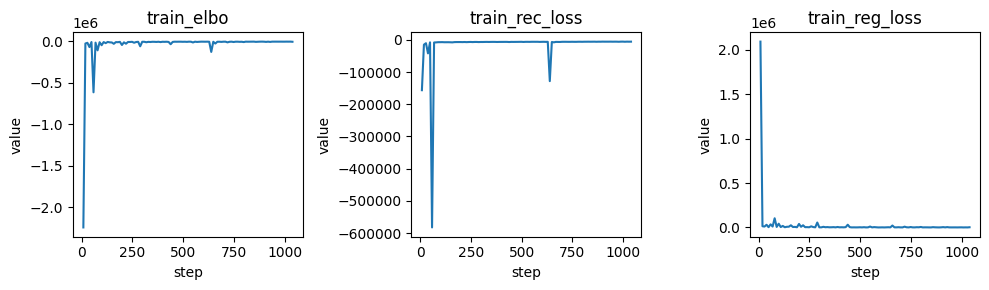

In [ ]:
*_, metrics_path = sorted((Path.cwd() / "cancer").iterdir(), key=lambda path: path.stat().st_ctime)
print(f"Reading results in '{metrics_path}'")

metrics = pd.read_csv(metrics_path / "metrics.csv").melt(id_vars=["step", "epoch"])

fig, axs = plt.subplots(ncols=3, figsize=(10, 3))

for i, metric in enumerate(["train_elbo", "train_rec_loss", "train_reg_loss"]):
    subset = metrics[lambda df: df.variable == metric]
    sns.lineplot(data=subset, x="step", y="value", ax=axs[i])
    axs[i].set_title(metric)

fig.tight_layout()

## Testing Our Model

### Latent Space Analysis

Final step after training our model is testing how good it is. We start by first checking its ability to compress the data into a meaningful latent space. We start by freezing the weights of the model so they are no longer updated, and then do a forward pass through each mini-batch of the test dataset.

Once we have our latent space, we will use t-SNE to reduce its dimensions so we can have a better visualization. We will reduce the number of dimensions to 2.

In [ ]:
model.freeze()  # stop weights from being updated

latent_space = []
labels = []
for batch in test_dataloader:
    x, y = batch
    z = model.project(x)
    latent_space.append(z)
    labels.append(y)

latent_space = torch.cat(latent_space, dim=0)
latent_space_2d = TSNE(n_components=2).fit_transform(latent_space)

labels = torch.cat(labels, dim=0)

From the plot below, we can see clusters for each cancer type. Our model has learned how to compress gene expression data into meaningful clusters. Note that we didn't supply this information to the model, the data went unlabeled. For this reason VAEs are called unsupervised methods.

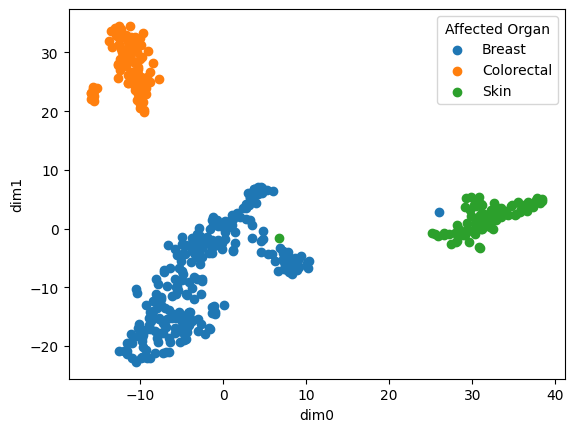

In [ ]:
fig, ax = plt.subplots()

for i, cls_ in enumerate(classes):
    subset = latent_space_2d[labels == i, :]
    ax.scatter(subset[:, 0], subset[:, 1], label=cls_)

ax.set(xlabel="dim0", ylabel="dim1")
ax.legend(title="Affected Organ");

### Reconstruction Accuracy

Let's check how good the reconstructions that the model generates are. In the following plots, we have the original values from the dataset in the $x$-axis and the reconstrcuted values in the $y$-axis. We plot the results of only 4 genes (those with the smallest mean squared error), but there are many other genes in the dataset.

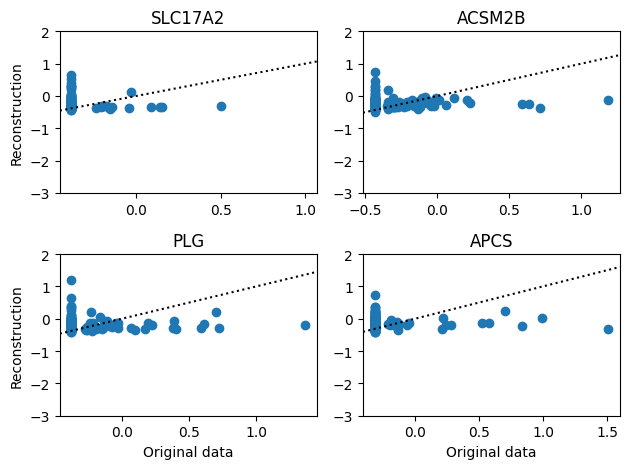

In [ ]:
original_values = []
reconstructions = []
for batch in test_dataloader:
    x, y = batch
    x_pred = model.reconstruct(x)
    original_values.append(x)
    reconstructions.append(x_pred)

original_values = torch.cat(original_values, dim=0)
reconstructions = torch.cat(reconstructions, dim=0)

sort_ids = np.argsort(mean_squared_error(original_values, reconstructions, multioutput="raw_values"))[:4].tolist()

fig, axs = plt.subplots(ncols=2, nrows=2)
axs = axs.flatten()

feature_names = trans.columns[sort_ids].tolist()

for i, (ax, idx) in enumerate(zip(axs, sort_ids)):
    ax.scatter(original_values[:, idx], reconstructions[:, idx])
    ax.axline((1, 1), slope=1, linestyle=":", color="k")
    ax.set(ylim=(-3, 2))
    if i == 0 or i == 2:
      ax.set(ylabel="Reconstruction")
    if i >= 2:
      ax.set(xlabel="Original data")

fig.tight_layout()

**Question.** Now, look at the worst reconstructions. Why do you think that was the case and how could these be improved?

<textarea id="answer" name="answer" cols="80" rows="4"></textarea>

<details>
<summary>Click to answer</summary>
Look back at the original data and plot the histogram of some the transcript measurements. Remember our decoder models data using a normal distribution, does that match how the data is naturally distributed?

One possible solution would be to ensure our data has a Gaussian distribution (to match our decoder output) by first going through z-score normalization/standardization.
</details>


## Next Steps

Repeat the above steps, but play around with the hyperparameters. How does learning rate, batch size, KL weight, activation function, and network architecture (number of hidden units in the information bottleneck) affect the loss curve, the quality of the reconstructions, and the clustering in the latent space?

## Conclusion

To conlude, let's do a quick re-cap:

1. VAEs are probabilistic models that model the distribution of a set of latent features that describe our inputs/observations.
2. VAEs have an encoder and decoder that compress/decompress data, respectively.
3. Trained encoders can be used to project data into a low-dimensional space, which can be used for clustering.
4. Trained decoders can be used to reconstruct the data from a sample of the latent space.


Thanks for joining our workshop! If you wish to continue learning about VAEs and try your hand at another (more complex) exercise, we invite you to try following the instructions in our [multi-omics integration](https://broad.io/MoveNotebook) notebook. Therein, we present MOVE (multi-omics variational autoencoder) and provide a guide on how to use our tool for analysis of multi-omics datasets.